# (06) SLC: entropy rank + shared colorbars

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig6_Entropy'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig6_Entropy

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc=20)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Entropy

In [4]:
%%time

for mode, o in bt_dict.items():
    o.compute_entropy(
        use_prune=True,
        select_seeds=True if
        mode == BOLD else False,
    )

CPU times: user 3min 20s, sys: 6.27 s, total: 3min 26s
Wall time: 3min 26s


In [5]:
ent = {mode: avg(o.run_h, 1) for mode, o in bt_dict.items()}
{mode: bt.symmetry_score(avg(h, 1))[0][-1] for mode, h in ent.items()}

{'BOLD': 0.86, 'Ca$^{2\\!\\!+}_{slow}$': 0.934, 'Ca$^{2\\!\\!+}_{fast}$': 0.945}

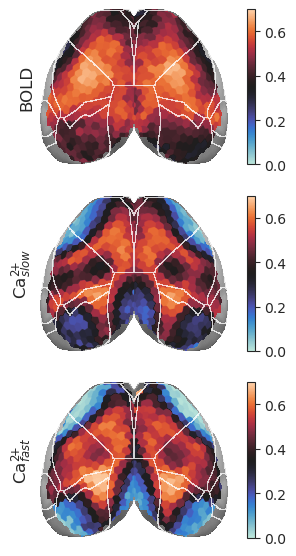

In [6]:
_ = bt.show(
    data=ent,
    figsize=(5, 7),
    vmin=0,
    vmax=0.7,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

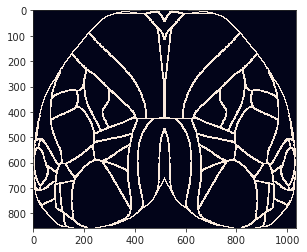

In [7]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

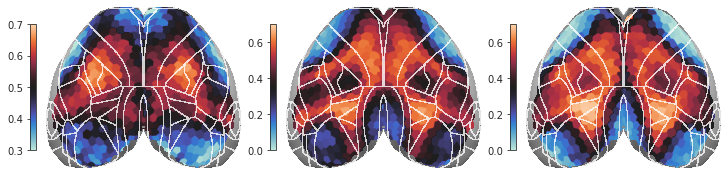

In [8]:
fig, axes = create_figure(1, 3, (10, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, ent.items()):
    x[x == 0] = np.nan
    
    if mode == BOLD:
        vmin = 0.3
        nbins = 4
    elif mode == CAS:
        vmin = 0
        nbins = 6
    elif mode == CAF:
        vmin = 0
        nbins = 6
    else:
        raise NotImplementedError
    vmax = vmax = 0.7
    
    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys',
        cbar_tick_nbins=nbins,
        cbar_aspect=20,
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

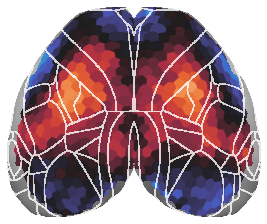

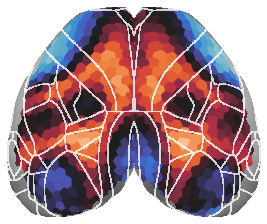

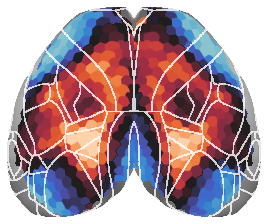

In [9]:
entr = {mode: avg(o.run_hr, 1) for mode, o in bt_dict.items()}

for i, fig_name in {0: 'BOLD', 1: 'CAS', 2: 'CAF'}.items():
    fig, ax = create_figure(1, 1, (4, 3), tight_layout=False, constrained_layout=True)
    mode, x = list(entr.items())[i]
    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=0,
        vmax=0.9,
        cbar=False,
        cmap='icefire',
        cbar_shrink=0.7,
        contour=contour,
    )
    remove_ticks(ax)
    fig.savefig(pjoin(fig_dir, f'ctx_rank_{fig_name}.png'), **kws_fig)
    plt.show()

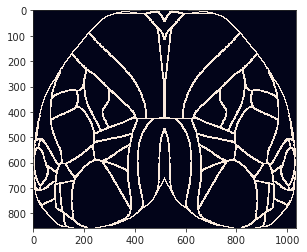

In [10]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

### Ranks

In [11]:
ent_rank = {}
for mode, o in bt_dict.items():
    ent_rank[mode] = o.run_hr.reshape(-1, o.run_hr.shape[-1])

good_runs = ~functools.reduce(
    np.logical_or,
    [np.isnan(e).sum(1) == e.shape[-1] for e in ent_rank.values()]
)
ent_rank = {k: v[good_runs] for k, v in ent_rank.items()}
ent_rank = {k: bn.nanmean(v, 0) for k, v in ent_rank.items()}

good_runs.sum()

108

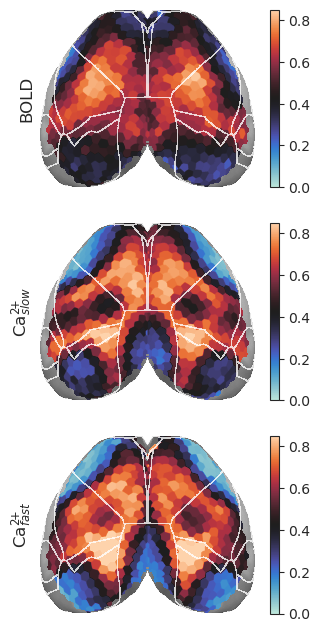

In [12]:
_ = bt.show(
    data=ent_rank,
    figsize=(4, 8),
    vmin=0,
    vmax=0.85,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

### Ranks (plot save)

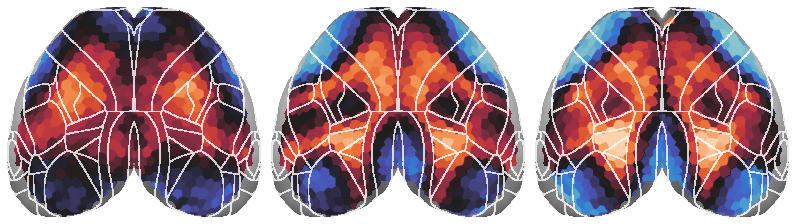

In [13]:
fig, axes = create_figure(1, 3, (11, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, ent_rank.items()):
    x[x == 0] = np.nan

    vmin = 0
    vmax = 0.9
    nbins = 5

    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        # cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys',
        # cbar_tick_nbins=nbins,
        # cbar_aspect=20,
        cbar=False,
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'nocbar_ctx_rank.png'), **kws_fig)

plt.show()

### Actual values, no cbar (plot save)

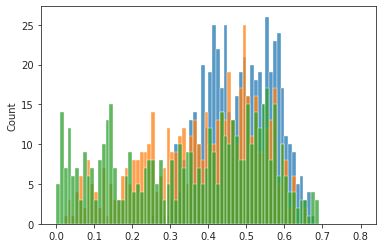

In [14]:
sns.histplot(ent[BOLD], color='C0', bins=np.linspace(0, 0.8, 81))
sns.histplot(ent[CAS], color='C1', bins=np.linspace(0, 0.8, 81))
sns.histplot(ent[CAF], color='C2', bins=np.linspace(0, 0.8, 81));

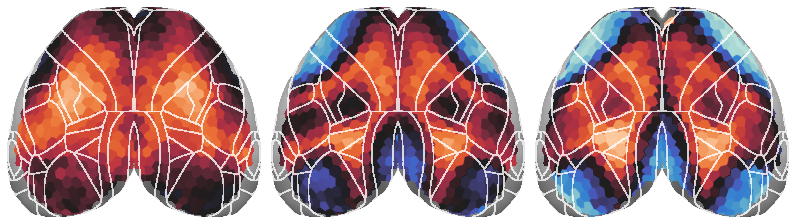

In [15]:
fig, axes = create_figure(1, 3, (11, 3), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, ent.items()):
    x[x == 0] = np.nan

    vmin = 0
    vmax = 0.70
    nbins = 5

    ax, cbar = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        # cbar_shrink=0.6,
        contour=contour,
        contour_cmap='Greys',
        # cbar_tick_nbins=nbins,
        # cbar_aspect=20,
        cbar=False,
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'nocbar_ctx.png'), **kws_fig)

plt.show()

## Colorbars

In [16]:
fig_dir = 'Figs_Cbar'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Figs_Cbar

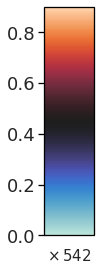

In [17]:
fig, cax, cbar = cbar_only('icefire', vmin=0, vmax=0.9, figsize=(0.9, 4.2), tick_position='left')
cax.tick_params(labelsize=18)
cax.text(
    x=0.05,
    y=-0.1,
    fontsize=15,
    s=r"$\times \, 542$",
)

fig.savefig(pjoin(fig_dir, 'icefire_rank.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'icefire_rank.pdf'), **kws_fig)
fig

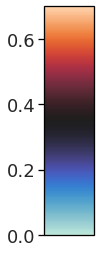

In [18]:
fig, cax, cbar = cbar_only('icefire', vmin=0, vmax=0.7, figsize=(0.9, 4.2), tick_position='left')
cax.tick_params(labelsize=18)

fig.savefig(pjoin(fig_dir, 'icefire.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'icefire.pdf'), **kws_fig)
fig

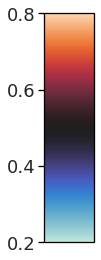

In [19]:
fig, cax, cbar = cbar_only('icefire', vmin=0.2, vmax=0.8, figsize=(0.9, 4.2), tick_position='left')
cax.tick_params(labelsize=18)

fig.savefig(pjoin(fig_dir, 'icefire_particip.png'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'icefire_particip.pdf'), **kws_fig)
fig

## What about other K? (ignore, was from before)

In [24]:
%%time

ent_all = {}
for num_k in [3, 7, 20]:
    bt_dict, props_bo, props_ca = default_props(mice, num_k, perc=15)
    for mode, o in bt_dict.items():
        o.compute_entropy(
            use_prune=True,
            select_seeds=False,
        )
        ent_all[(num_k, mode)] = avg(o.run_hr, 1)

CPU times: user 43 s, sys: 1min 23s, total: 2min 6s
Wall time: 2min 11s


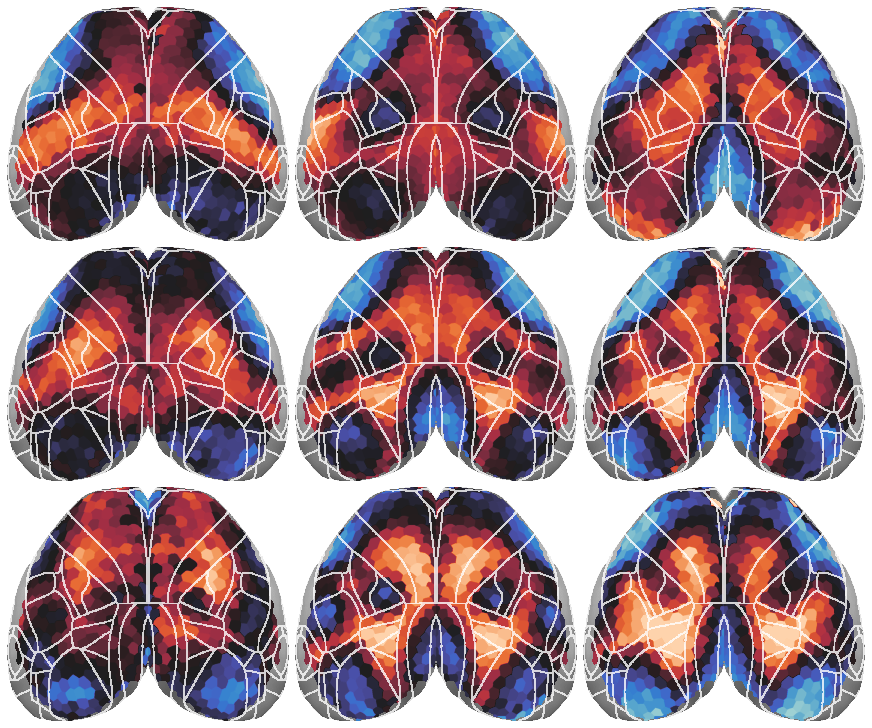

In [25]:
fig, axes = create_figure(
    nrows=3,
    ncols=3,
    figsize=(12, 10),
    tight_layout=False,
    constrained_layout=True,
)
vmin = 0
vmax = 0.9

for i, ((kk, mode), x) in enumerate(ent_all.items()):
    ax = axes.flat[i]
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap='icefire',
        contour=contour,
    )
    # ax.set_title(mode, y=1.05, fontsize=17)
    # ax.set_ylabel(f"K={kk}", fontsize=17)
remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'all_k_rank_ctx.png'), **kws_fig)
plt.show()

### This is old below:

In [148]:
h_all = collections.defaultdict(list)
hr_all = collections.defaultdict(list)
for i, (kk, dd) in enumerate(results.items()):
    for j, (mode, o) in enumerate(dd.items()):
        x = avg(o.run_h, 1)
        h_all[mode].append(np.expand_dims(x, 0))
        x = avg(o.run_hr, 1)
        hr_all[mode].append(np.expand_dims(x, 0))      
h_all = {k: np.concatenate(x) for k, x in h_all.items()}
hr_all = {k: np.concatenate(x) for k, x in hr_all.items()}

In [149]:
kwargs = {
    'l_colors': '#0C75C0',
    'r_colors': '#C0570C',
    'ticksize': 10,
    'ticks': True,
    'cmap': get_hm_cmap(),
    'fmt': '.2g', # 's',
    'vmin': 0.0,
    'vmax': 1.0,
    'linewidths': 0.01,
    'image_th': 0.0,
    'annot_th': 0.3,
    'annot_fontsize': 13,
    'annot_fontname': 'Loma',
    'cbar_aspect': 35,
    'cbar_shrink': 1.0,
    'tight_layout': False,
    'constrained_layout': True,
}

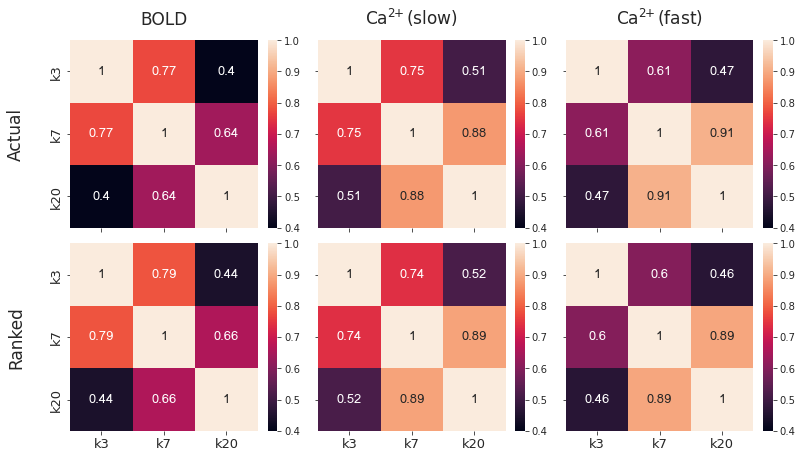

In [150]:
fig, axes = create_figure(2, 3, (11, 6.2), 'all', 'all', tight_layout=False, constrained_layout=True)

for i, dd in enumerate([h_all, hr_all]):
    for j, (mode, x) in enumerate(dd.items()):
        ax = axes[i, j]
        sim = dist2sim(sp_dist.squareform(sp_dist.pdist(
            X=x[:, np.isnan(x).sum(0) == 0],
            metric='correlation',
        )))
        sns.heatmap(
            data=sim,
            fmt='.2g',
            annot=True,
            square=True,
            cmap='rocket',
            cbar_kws={'shrink': 1},
            annot_kws={
                'fontsize': kwargs['annot_fontsize'],
                'fontname': kwargs['annot_fontname']},
            vmin=0.4,
            vmax=1.0,
            ax=ax,
        )
        tick_labels = [f"k{k}" for k in results]
        ax.set(
            xticklabels=tick_labels,
            yticklabels=tick_labels,
        )
        ax.tick_params(axis='both', labelsize=13)
        if i == 0:
            ax.set_title(mode, fontsize=17, y=1.05)
            if j == 0:
                ax.set_ylabel('Actual', labelpad=25, fontsize=17)
        else:
            if j == 0:
                ax.set_ylabel('Ranked', labelpad=25, fontsize=17)
                
fig.savefig(pjoin(fig_dir, 'all_k_sim.png'), **kws_fig)
plt.show()